In [9]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [10]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

# Prediction Import

In [11]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
df = pd.read_csv('predict.csv', index_col=0)
predict = df.drop('true', axis=1)
true = df['true']
del df
true_encoded = true.map(lambda x: LABELS[x])
true_encoded.name = 'true_label'
predict.columns = LABELS
predict.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking
0,1.138999e-30,6.174217e-21,0.000000e+00,0.000000e+00,5.277399e-15,1.000000e+00
1,1.350584e-14,4.242487e-19,9.999993e-01,6.892336e-07,1.942173e-13,3.192409e-14
2,2.364339e-10,5.979838e-17,1.057709e-16,1.894472e-19,9.999995e-01,4.966661e-07
3,2.128913e-11,1.000000e+00,4.239013e-26,2.703807e-28,3.320438e-10,2.187040e-19
4,7.961022e-10,8.042721e-14,1.931783e-05,9.999795e-01,1.163801e-06,2.807630e-09


In [12]:
# min-max normalization
# predict = predict.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
# predict = predict.apply(lambda x: x / x.sum(), axis=1)

predict_label = predict.idxmax(axis=1)
predict_probability = predict.max(axis=1)
predict_probability.name = 'predict_probability'
predict_label.name = 'predict_label'
# predict.head()
# true.head()
# true_encoded.head()

In [13]:
df = pd.concat([
            predict,
            predict_probability,
            true,
            predict_label,
            true_encoded
        ], axis=1)
df.head(10)

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,true,predict_label,true_label
0,1.138999e-30,6.174217e-21,0.000000e+00,0.000000e+00,5.277399e-15,1.000000e+00,1.000000,0,Walking,Downstairs
1,1.350584e-14,4.242487e-19,9.999993e-01,6.892336e-07,1.942173e-13,3.192409e-14,0.999999,0,Sitting,Downstairs
2,2.364339e-10,5.979838e-17,1.057709e-16,1.894472e-19,9.999995e-01,4.966661e-07,1.000000,0,Upstairs,Downstairs
3,2.128913e-11,1.000000e+00,4.239013e-26,2.703807e-28,3.320438e-10,2.187040e-19,1.000000,0,Jogging,Downstairs
4,7.961022e-10,8.042721e-14,1.931783e-05,9.999795e-01,1.163801e-06,2.807630e-09,0.999980,0,Standing,Downstairs
5,0.000000e+00,2.561100e-24,0.000000e+00,0.000000e+00,7.636685e-29,1.000000e+00,1.000000,0,Walking,Downstairs
6,9.999934e-01,2.127868e-11,7.578826e-13,3.445818e-14,6.331859e-07,5.956243e-06,0.999993,0,Downstairs,Downstairs
7,1.000000e+00,1.628833e-19,3.234642e-18,6.120775e-20,9.528659e-13,3.004413e-08,1.000000,0,Downstairs,Downstairs
8,2.174241e-16,1.000000e+00,0.000000e+00,7.488351e-36,9.621420e-16,6.652709e-29,1.000000,0,Jogging,Downstairs
9,1.319813e-35,2.828076e-15,0.000000e+00,0.000000e+00,1.342787e-21,1.000000e+00,1.000000,0,Walking,Downstairs


Accuracy:  0.08971713002306665


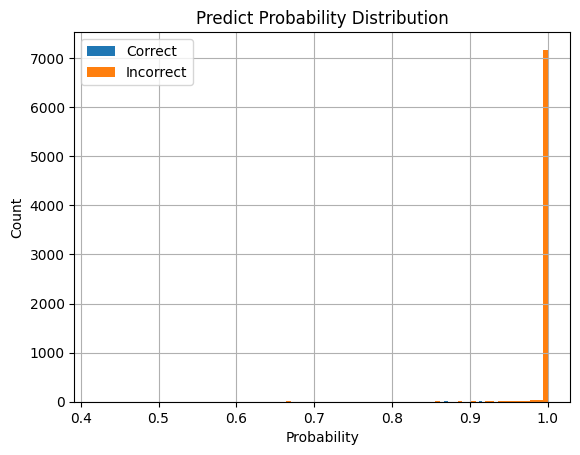

In [14]:
print('Accuracy: ', calc_accuracy(df))
# statival analysis
df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100)
plt.title('Predict Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [15]:
df['predict_probability'].agg(['mean', 'std', 'min', 'max', 'median'])

mean      0.991571
std       0.049012
min       0.420901
max       1.000000
median    1.000000
Name: predict_probability, dtype: float64

In [16]:
thresholds = [0, 0.7, 0.9, 0.99, 0.999, 0.99999,]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    cm = confusion_matrix(df_confidence['true_label'], df_confidence['predict_label'])
    cm_df = pd.DataFrame(cm, index=LABELS, columns=LABELS)
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        linewidths=0.5,
        cmap="Blues",
        cbar=False,
        annot_kws={"size": 14},
        square=True,
    )
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig(f'confusion_matrix/threshold{threshold}.png')
    plt.close()
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_290392/3327794854.py:2: RuntimeWarning: invalid value encountered in long_scalars
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.00000,0.089717,1.000000,0.000000,0.000000
0.70000,0.087495,0.989316,0.295455,0.010684
0.90000,0.083468,0.974505,0.328571,0.025495
0.99000,0.075122,0.943790,0.334773,0.056210
0.99900,0.065798,0.913318,0.341737,0.086682
0.99999,0.043654,0.839869,0.331312,0.160131
